In [ ]:
import os
import shutil
import numpy 
import pandas 
import matplotlib
import random
seed = 1
random.seed(seed)
directory = "/content/drive/MyDrive/Data /ISIC2020/RawData/" 
train = "/content/drive/MyDrive/Data /ISIC2020/train/"
test = "/content/drive/MyDrive/Data /ISIC2020/test/"
validation = "/content/drive/MyDrive/Data /ISIC2020/validation/"

os.makedirs(train + "/benign/")
os.makedirs(train + "/malignant/")

os.makedirs(test + "/benign/")
os.makedirs(test + "/malignant/")
os.makedirs(validation + "/benign/")
os.makedirs(validation + "/malignant/")
test_examples = train_examples = validation_examples = 0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New section

In [ ]:
import pandas
df = pandas.read_csv("/content/drive/MyDrive/Data /ISIC2020/ISIC_2020_Training_GroundTruth.csv", nrows=25)
for name, dtype in df.dtypes.iteritems():
    print(name, dtype)

image_name object
patient_id object
sex object
age_approx int64
anatom_site_general_challenge object
diagnosis object
benign_malignant int64
target int64


In [ ]:
for line in open("/content/drive/MyDrive/Data /ISIC2020/ISIC_2020_Training_GroundTruth.csv").readlines()[1:]:
    split_line = line.split(",")
    img_file = split_line[0]
    benign_malign = split_line[6]
    random_num = random.random()
    if random_num < 0.6:
        location = train
        train_examples += 1
    elif random_num < 0.8:
        location = validation 
        validation_examples += 1
    else:
        location = test
        test_examples += 1
    if int(float(benign_malign)) == 0:
        shutil.copy("/content/drive/MyDrive/Data /ISIC2020/RawData/" + img_file + ".jpg", location + "benign/" + img_file + ".jpg",)
    elif int(float(benign_malign)) == 1:
        shutil.copy("/content/drive/MyDrive/Data /ISIC2020/RawData/" + img_file + ".jpg",
                location + "malignant/" + img_file + ".jpg",)
       

KeyboardInterrupt: ignored

In [ ]:
print(f" number of train example {train_examples}")
print(f" number of test example {test_examples}")
print(f" number of validation example {validation_examples}")

NameError: ignored

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import keras
import tensorflow as tf
import math
import tensorflow_hub as hub
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_examples = 15242
test_examples = 5106
validation_examples = 4983

img_height = img_width = 224
batch_size = 50

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4",
                   trainable=True),  # Can be True, see below.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#model = keras.model.load_model("isic_model/")

train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 15, 
    zoom_range = (0.95, 0.95),
    horizontal_flip= True, 
    vertical_flip = True,
    data_format = "channels_last",
    dtype = tf.float32,
)

validation_datagen = ImageDataGenerator(rescale = 1.0/255, dtype = tf.float32)
test_datagen = ImageDataGenerator(rescale = 1.0/255, dtype = tf.float32)

train_gen = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Data /ISIC2020/train",
    target_size =(img_height, img_width),
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode="binary",
    shuffle= True,
    seed = 123,
)
validation_gen = validation_datagen.flow_from_directory(
    "/content/drive/MyDrive/Data /ISIC2020/validation",
    target_size =(img_height, img_width),
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode="binary",
    shuffle= True,
    seed = 123,
)
test_gen = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/Data /ISIC2020/test",
    target_size =(img_height, img_width),
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode="binary",
    shuffle= True,
    seed = 123,
)

METRICS = [
    keras.metrics.BinaryAccuracy(name = "accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc")
]



Found 10107 images belonging to 2 classes.
Found 3287 images belonging to 2 classes.
Found 3388 images belonging to 2 classes.


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(lr = 3e-4),
    loss=[keras.losses.BinaryCrossentropy(from_logits=False)],
    metrics= METRICS, #["accuracy"]
)

history= model.fit(
    train_gen,
    epochs=5,
    verbose=2,
    steps_per_epoch= train_examples // batch_size,
    validation_data = validation_gen,
    validation_steps = validation_examples // batch_size,
)


def plot_roc(labels, data):
    predictions = model.predict(data)
    fp,tp, _ = roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp)
    plt.xlabel("False positive [%]")
    plt.ylabel("True positive [%]")
    plt.show()
test_labels = np.array([])
num_batches = 0

for _, y in test_gen:
    test_labels = np.append(test_labels, y)
    num_batches += 1
    if num_batches == math.ceil(test_examples / batch_size):
        break

plot_roc(test_labels, test_gen)

model.evaluate(validation_gen, verbose =2)
model.evaluate(test_gen,verbose = 2)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


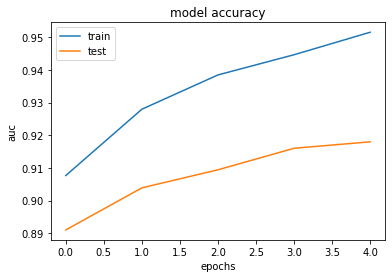

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('auc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')



dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


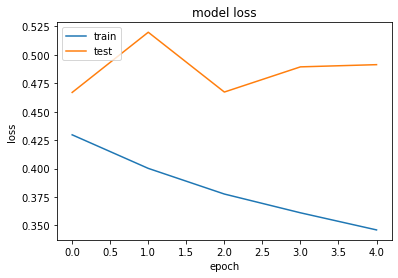

In [ ]:
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(train_gen, verbose =2)
model.evaluate(test_gen,verbose = 2)

305/305 - 2174s - loss: 0.3513 - accuracy: 0.9129 - precision: 0.9256 - recall: 0.5530 - auc: 0.9583
103/103 - 522s - loss: 0.4664 - accuracy: 0.8780 - precision: 0.7304 - recall: 0.4793 - auc: 0.8694


[0.4664296507835388,
 0.8779866695404053,
 0.7303754091262817,
 0.47928330302238464,
 0.8693988919258118]